# Analyse des rapports de l'OPECST

Ce document vise à réunir les analyses des rapports de l'OPECST, avec la phase de récupération des données d'une part, puis de l'analyse des informations recodées à la main

In [259]:
import sqlite3 as sq
import bs4 as bs
import re
import locale
import glob
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import os as os
import bs4 as bs
import networkx as nx
import metaknowledge as mt
%matplotlib inline
plt.style.use('ggplot')
pd.options.display.max_colwidth = 10000

# Récupération des informations des rapports sur le site de l'AN

In [2]:
url = "http://www.assemblee-nationale.fr/documents/index-general-oecst.asp"
p = req.get(url).text
p = bs4.BeautifulSoup(p,"html.parser")
t = p.find_all("tr")
tt = [i for i in t if "n°" in i.text]

In [58]:
def clean_names(x):
    return x.replace(" et ",";").replace("MM. ","").replace("(","").replace(")","").replace("M. ","")\
        .replace("Mme ","").replace(",",";")
def clean_entry(x):
    try:
        url = "http://www.assemblee-nationale.fr"+x.find("a")["href"]
    except:
        url = None
    t = x.text.split("\n")
    return [t[0].strip(),t[1],clean_names(t[2]),url]

In [68]:
ttt = [clean_entry(i) for i in tt]
ttt = pd.DataFrame(ttt)
ttt.columns = ["Identifiant","Titre","Rapporteurs","Lien"]
ttt["Type de rapport"] = None
ttt["Date de départ"] = None
ttt["Date de remise"] = None
ttt["Chambre responsable"] = None
ttt["Nombre auditions"] = None
ttt["Date auditions"] = None
ttt["Pays visités"] = None
tttt = ttt.set_index("Identifiant")
ttt.to_excel("Document de description des rapports.xls")

# Analyse des rapports

Recodage des données et ajustements

In [326]:
d = pd.read_csv("Document de description des rapports.xls.csv")
d["Date"] = pd.to_datetime(d["Date de remise"])
d["Number"] = 1
d = d.set_index("Date")
def replace(x,dic):
    for i in dic:
        x = x.replace(i,dic[i])
    return x
dic1 = {"nucléaires":"nucléaire","déchets":"déchet","dechets":"déchet","télécommunications":"télécommunication","energie":"énergie","electronique":"électronique","nuéclaire":"nucléaire"}
d["Thème principal"] = d["Thème principal"].apply(lambda x: replace(x.lower(),dic1).split(";"))
d["Rapporteurs"] = d["Rapporteurs"].apply(lambda x: x.lower().split(";"))
d["Pays visités"] = d["Pays visités"].apply(lambda x: None if pd.isnull(x) or x in ["/",0,"0"] else x.replace(" ","").lower().split(";"))

#Filtres
f1 = d["Type de rapport"]=="Rapport d'information"
f2 = d["Type de rapport"]=="Rapport d'actualité"
f3 = d["Type de rapport"]!="Rapport d'information"

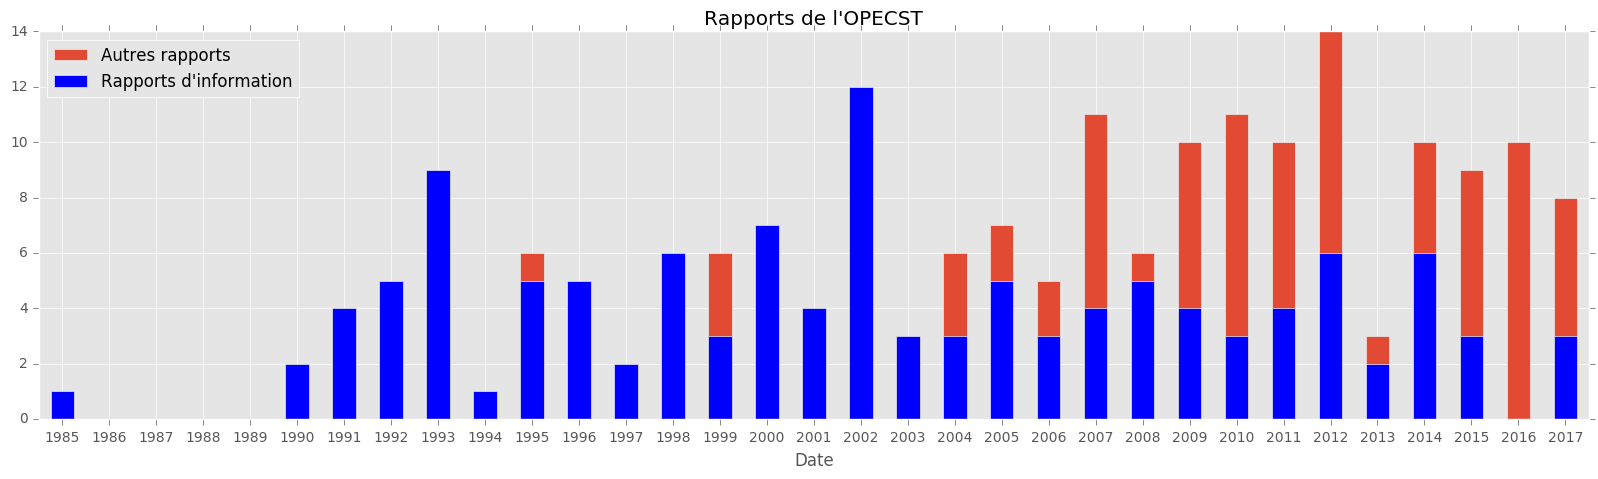

In [376]:
ax = d["Number"].resample("12M").sum().fillna(0).interpolate().plot(figsize=(20,5),kind="bar",rot=0)
d[f1]["Number"].resample("12M").sum().fillna(0).interpolate().plot(figsize=(20,5),kind="bar",rot=0,color="blue")
xtl=[item.get_text()[:4] for item in ax.get_xticklabels()]
ax.set_xticklabels(xtl)
plt.title("Rapports de l'OPECST")
plt.legend(["Autres rapports","Rapports d'information"],loc=0)

## Temps de réalisation

In [336]:
def diff_time(x):
        if pd.notnull(x["Date de remise"]) and pd.notnull(x["Date de départ"]) and not x["Date de départ"] in ["?","/"]:
            return pd.to_datetime(x["Date de remise"])-pd.to_datetime(x["Date de départ"])
        else:
            return None
        print(x["Date de remise"],x["Date de départ"])

d["Temps"] = d.apply(diff_time,axis=1)

(0, 5000.0)

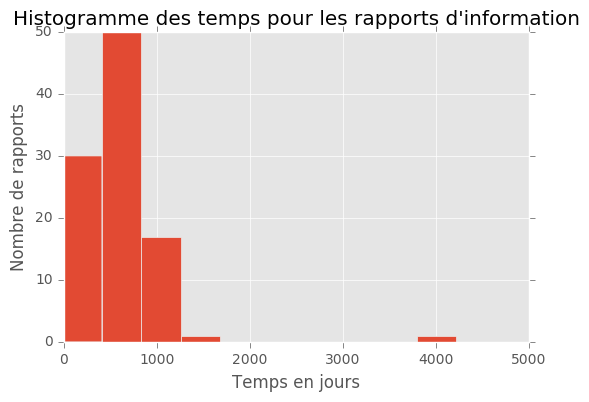

In [339]:
d[f1]["Temps"].dt.days.hist()
plt.title("Histogramme des temps pour les rapports d'information")
plt.ylabel("Nombre de rapports")
plt.xlabel("Temps en jours")
plt.xlim(0)

/Users/user/anaconda/envs/p3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
  if __name__ == '__main__':


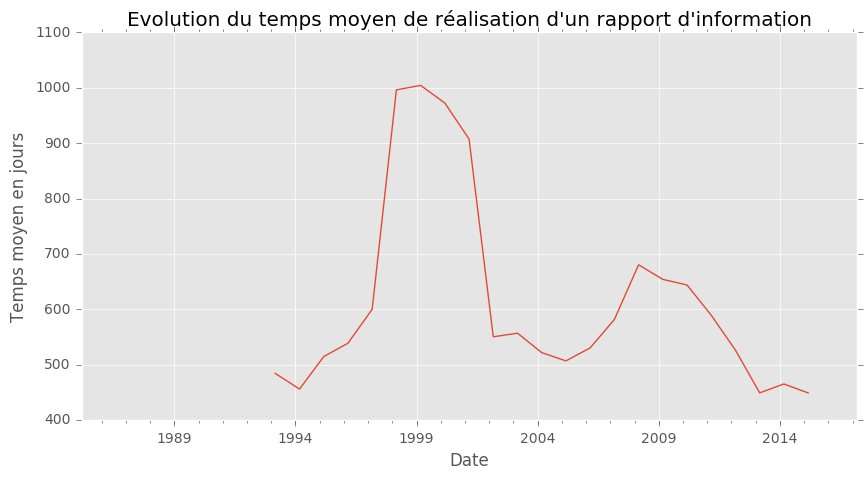

In [342]:
pd.rolling_mean(d[f1]["Temps"].dt.days.resample("12M").mean(),4).plot(figsize=(10,5))
plt.title("Evolution du temps moyen de réalisation d'un rapport d'information")
plt.ylabel("Temps moyen en jours")

## Nombre d'auditions publiques

In [182]:
d["Nombre auditions"] = d["Nombre auditions"].apply(lambda x : 0 if x in ["/","0"] else x).apply(lambda x: int(x) if pd.notnull(x) else x)
v = d[f1][["Nombre auditions","Number"]].fillna(0)
v = v[v["Nombre auditions"]<10] 
v["auditions"] = v["Nombre auditions"].apply(lambda x : 1 if x>0 else 0)
v = v.resample("24M").sum()

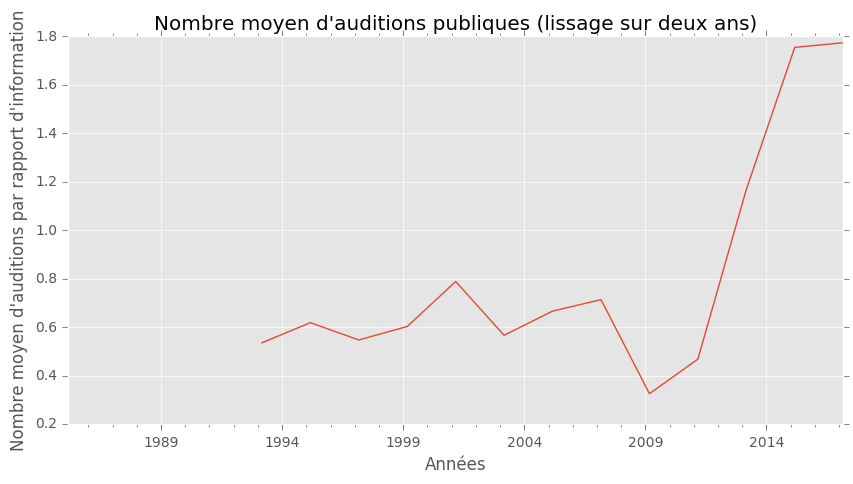

In [334]:
v["mean_nbre"] = v.apply(lambda x : x["Nombre auditions"]/(x["Number"]+0.01),axis=1)
v["mean_bin"] = v.apply(lambda x : x["auditions"]/(x["Number"]+0.01),axis=1)
v["mean_nbre"].rolling(2).mean().plot(figsize=(10,5))
plt.title("Nombre moyen d'auditions publiques (lissage sur deux ans)")
plt.xlabel("Années")
plt.ylabel("Nombre moyen d'auditions par rapport d'information")

## Analyse des rapporteurs

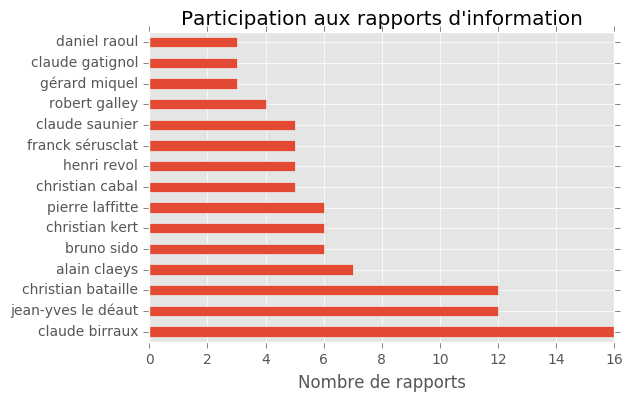

In [284]:
r = pd.Series([i for j in list(d[f1]["Rapporteurs"]) for i in j]).value_counts()
r[0:15].plot(kind="barh")
plt.title("Participation aux rapports d'information")
plt.xlabel("Nombre de rapports")

## Analyse des thématiques

codage spécifique

In [224]:
d["theme_nucleaire"] = d["Thème principal"].apply(lambda x : 1 if "nucléaire" in x else 0)
d["theme_sante"] = d["Thème principal"].apply(lambda x : 1 if "santé" in x else 0)
d["theme_recherche"] = d["Thème principal"].apply(lambda x : 1 if "recherche" in x else 0)
d["theme_energie"] = d["Thème principal"].apply(lambda x : 1 if "énergie" in x else 0)
d["theme_environnement"] = d["Thème principal"].apply(lambda x : 1 if "environnement" in x else 0)

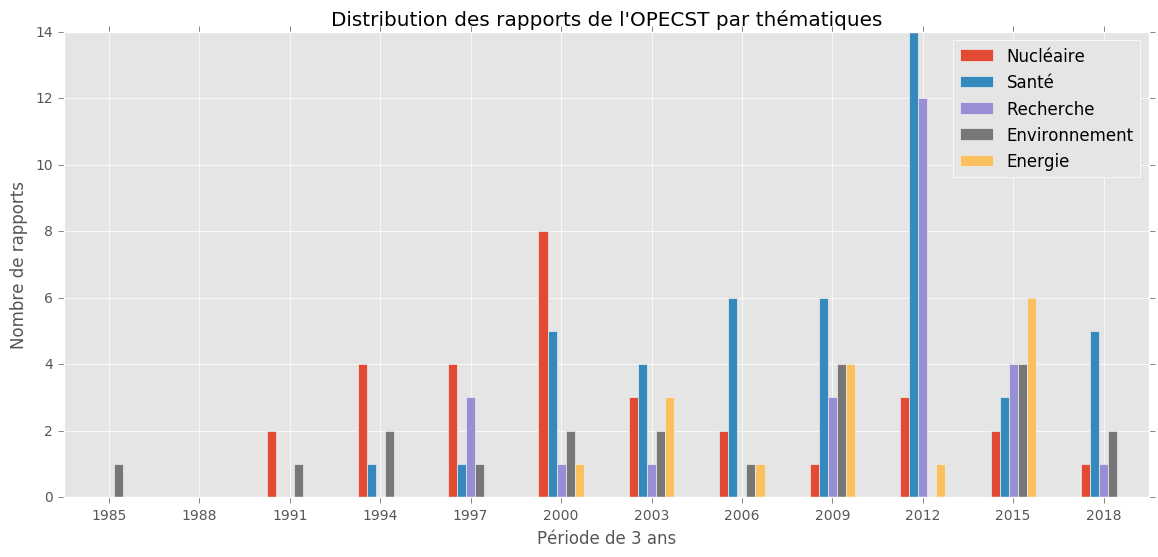

In [269]:
ax = d[["theme_nucleaire","theme_sante","theme_recherche","theme_environnement","theme_energie"]]\
.resample("36M").sum()\
.plot(kind="bar",figsize=(14, 6), rot=0)
plt.legend(["Nucléaire","Santé","Recherche","Environnement","Energie"])
plt.title("Distribution des rapports de l'OPECST par thématiques")
plt.ylabel("Nombre de rapports")
plt.xlabel("Période de 3 ans")

## Analyse des pays visités

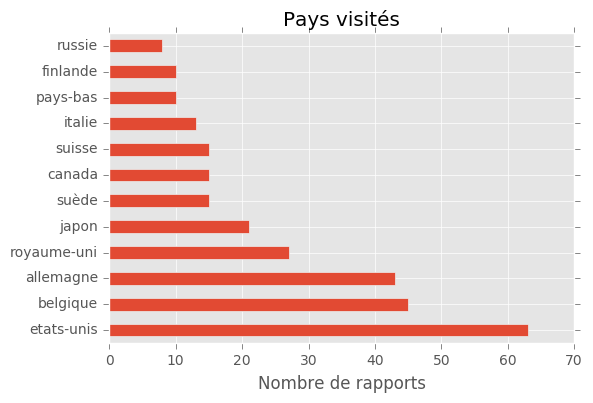

In [330]:
r = pd.Series([i for j in [i for i in list(d["Pays visités"]) if type(i)==list] for i in j]).value_counts()
r[0:12].plot(kind="barh")
plt.title("Pays visités")
plt.xlabel("Nombre de rapports")